# AirBnB Case
by David Keller



### Load required libraries

In [1]:
import os
import requests
import shutil
import gzip

import numpy as np
import pandas as pd
from operator import attrgetter

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

from difflib import SequenceMatcher
import re

import json

import folium
import folium.plugins


from tqdm import tqdm, trange
from dateutil.relativedelta import relativedelta
from datetime import datetime
%matplotlib inline

tqdm.pandas()

In [2]:
class DPReportHandler( object ) :
    """ a class to handle datapane 
        base class is empty in case you have no datapane available
    """
    
    def upload( self, name ) :
        pass
    
    def add_plot( self, content, tag ) :
        pass
    
    def add_table( self, content, tag ) :
        pass
    
    def add_text( self, content, tag ) :
        pass

dp_report = DPReportHandler()
    
try :
    import datapane
    
    class RealDPReportHandler( DPReportHandler ) :
        """ a class to handle datapane reports
            collects datapane blocks internally before uploading
            hides the datapane.Report api internally, no need to rewrite
            the notebook in case you have no datapane available
            
            embedding specific blocks is a beta feature and does not
            work as expected in medium. Hence, all blocks are uploaded as
            separate reports here
        """
        
        def __init__( self ) :
            from config import datapane_token
            datapane.login( token=datapane_token )
            
            self._blocks = dict()
            
        def add_plot( self, content, tag ) :
            self._blocks[tag] = datapane.Plot( content, tag )
        
        def add_table( self, content, tag ) :
            self._blocks[tag] = datapane.Table( content, tag )
            
        def add_text( self, content, tag ) :
            self._blocks[tag] = datapane.Text( content, tag )
        
        def upload( self, name ) :
            for tag, block in self._blocks.items() :
                report = datapane.Report( block, tag )
                report.upload( name + "_" + tag, 
                              formatting=datapane.ReportFormatting( width = datapane.ReportWidth.MEDIUM ) )
    
    
    dp_report = RealDPReportHandler()
        
    print( "Datapane configured" )
        
except :
    # if we do not have an api key available
    pass

Connected successfully to https://datapane.com as david17
Datapane configured


### Load airbnb Data

#### Download data if they do not exist

In [3]:
inside_airbnb_urls = {
        "vaud" : {
            "listings" : "http://data.insideairbnb.com/switzerland/vd/vaud/2021-12-04/data/listings.csv.gz",
            "calendar" : "http://data.insideairbnb.com/switzerland/vd/vaud/2021-12-04/data/calendar.csv.gz",
            "reviews" : "http://data.insideairbnb.com/switzerland/vd/vaud/2021-12-04/visualisations/reviews.csv" },
        "geneva" : {
            "listings" : "http://data.insideairbnb.com/switzerland/geneva/geneva/2021-12-26/data/listings.csv.gz",
            "calendar" : "http://data.insideairbnb.com/switzerland/geneva/geneva/2021-12-26/data/calendar.csv.gz",
            "reviews" : "http://data.insideairbnb.com/switzerland/geneva/geneva/2021-12-26/data/reviews.csv.gz" },
        "zurich" : {
            "listings" : r'http://data.insideairbnb.com/switzerland/zürich/zurich/2021-12-28/data/listings.csv.gz',
            "calendar" : r'http://data.insideairbnb.com/switzerland/zürich/zurich/2021-12-28/data/calendar.csv.gz',
            "reviews" : r'http://data.insideairbnb.com/switzerland/zürich/zurich/2021-12-28/data/reviews.csv.gz' }
        }

In [4]:
for city, urls in tqdm( inside_airbnb_urls.items() ) :
    for suffix, url in urls.items() :
        filename = os.path.join("./data/airbnb_%s" % city, suffix + ".csv.gz")
        # download file, if it does not exist
        if not os.path.isfile(filename):
            response = requests.get(url, stream=True)
            if response.ok:
                with open(filename, 'wb') as csvfile:
                    for chunk in response.raw.stream(1024, decode_content=False) :
                        if chunk :
                            csvfile.write( chunk )

100%|██████████| 3/3 [00:00<00:00, 4279.90it/s]


#### Load data into pandas

In [5]:
def load_data( city ) :
    calendar = pd.read_csv('./data/airbnb_%s/calendar.csv.gz' % city )
    listings = pd.read_csv('./data/airbnb_%s/listings.csv.gz' % city )
    reviews = pd.read_csv('./data/airbnb_%s/reviews.csv.gz' % city )
    calendar["city"] = city
    listings["city"] = city
    reviews["city"] = city
    return calendar, listings, reviews

In [6]:
calendar = listings = reviews = pd.DataFrame()

for city in tqdm( ["zurich", "geneva", "vaud"] ):
    cal, li, rev = load_data( city )
    calendar = pd.concat( [calendar, cal], axis=0 )
    listings = pd.concat( [listings, li], axis=0 )
    reviews = pd.concat( [reviews, rev], axis=0 )

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


#### Initial cleaning

In [7]:
listings.shape

(8651, 75)

Drop columns with urls and columns with neighbourhood information. We do not use them here.

In [8]:
for col in listings.columns :
    if col.endswith( "url" ) or ("neighbourhood" in col) :
        listings.drop( col, axis=1, inplace=True )

In [9]:
listings.columns

Index(['id', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'host_id', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'latitude', 'longitude', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews',
       'number_of_reviews_ltm', 'numbe

## Understand the Business of AirBnB

* What is the market offer?
   * Where are the best rooms?
   * What kind of appartment is typically for rent?
   * What are the prices?
* What can you tell about the reviewers?
    * How does the number of reviews develop over time?
    * Are there effects over seasons, years or day of weeks for the reviews?
    * Are reviewers revisiting or changing their favorite rooms?
* How can you optimize your revenue on AirBnB as a host?
    * How can we model revenue?
    * How can we determine, what has an influence on the revenue?

## Market

### Question: What are the best scoring locations?

In [10]:
df_loc = listings[["latitude", "longitude", "review_scores_location"]]

Check if we have longitude and latitude for every listing.

In [11]:
df_loc.longitude.isnull().sum() == 0 and df_loc.latitude.isnull().sum() == 0

True

What percentage of location scores is NaN?

In [12]:
df_loc.review_scores_location.isnull().sum()/df_loc.shape[0]

0.24020344468847532

Roughly one two fifth of rows are without a score for the location. We could either drop these before processing or inject a mean value. We follow the second approach here. If a guest does not review the location, we assume he has a neutral opinion here without ups or downs.

In [13]:
df_loc_filled = df_loc.fillna( value=df_loc.review_scores_location.mean(), axis=0 )

Make a plot to get an understanding of the best rated locations.

In [14]:
m = folium.Map(location = [( df_loc_filled.latitude.min() + df_loc_filled.latitude.max() )/2,
                           ( df_loc_filled.longitude.min() + df_loc_filled.longitude.max() )/2], 
               tiles='Stamen toner', zoom_start = 8.)
folium.plugins.HeatMap( 
    df_loc_filled, name="Review Score Location", radius=5.,blur=6. ).add_to( m )
dp_report.add_plot( m, "review_score_location" )
m

Bokeh version 2.1.1 is not supported, these plots may not display correctly, please install version ~=2.2.0


### Question: What kind of room is for rent?


#### Get an Idea of Room Types

AirBnB has different room types in its database. A description is available [here](https://www.airbnb.com/help/article/5/what-does-the-room-type-of-a-listing-mean).
Do we have a room_type for every listing?

In [15]:
listings.room_type.notnull().all()

True

In [16]:
listings.room_type.value_counts()/listings.shape[0]

Entire home/apt    0.693215
Private room       0.294995
Hotel room         0.005895
Shared room        0.005895
Name: room_type, dtype: float64

Two thirds of the listings are entire homes. 29% are private rooms. Shared rooms and hotel rooms are negligible. 

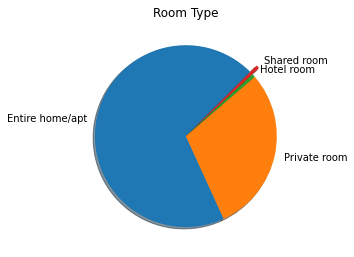

In [17]:
ax = listings.room_type.value_counts().plot.pie( shadow=True, figsize=(5,5), explode=(0, 0, 0, 0.1), startangle=45 )
ax.set_ylabel( None )
ax.set_title( "Room Type" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "room_type" )

#### Have a Look at Amenities

The amenities column contains a list of features. Take care, the list is in fact a string.

In [18]:
listings.amenities.head()

0    ["Hot tub", "Heating", "Elevator", "Dryer", "C...
1    ["Fire extinguisher", "Air conditioning", "Ind...
2    ["Stove", "Bed linens", "Elevator", "Microwave...
3    ["Lock on bedroom door", "Heating", "Elevator"...
4    ["Free parking on premises", "Heating", "Eleva...
Name: amenities, dtype: object

We split these into seperate columns for further processing.

In [19]:
def split_amenities( amenities_str ) :
    """
        Transform amenities from a string representation of a list into a pandas.Series which can be used to build new columns
        
        Parameters:
        amenities_list(str): A list of features in string representation
        
        Returns:
        pandas.Series: columns are lowercased entries of input list with blanks replaced by underscore, values are [True/False]
    
    """
    res = dict()
    try :
        for key in json.loads( amenities_str ) :
            res[key.lower().replace( " ", "_" )] = 1
    except :
        pass
    return pd.Series( res, dtype="bool" )

In [20]:
amenities = listings.amenities.apply( split_amenities ).fillna( 0 )

In [21]:
amenities.describe()

,hot_tub,heating,elevator,dryer,cable_tv,tv_with_standard_cable,washer,wifi,lake_access,essentials,...,four_micro-onde_combiné_grill_marque_weber_oven,no_body_soap,no_shampoo,yes_oven,yes_refrigerator,"hdtv_with_chromecast,_netflix,_standard_cable",pain_de_savon_bio__body_soap,"divers_(nuxe,_le_petit_marseillais,_well...)_body_soap","divers_(nuxe,_le_petit_marseillais,_well...)_shampoo","divers_(nuxe,_le_petit_marseillais,_well...)_conditioner"
count,8651,8651,8651,8651,8651,8651,8651,8651,8651,8651,...,8651,8651,8651,8651,8651,8651,8651,8651,8651,8651
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,0,True,0,0,0,0,True,True,0,True,...,0,0,0,0,0,0,0,0,0,0
freq,8404,7223,5249,4527,6642,6738,5631,7895,7595,7702,...,8650,8650,8650,8650,8650,8650,8650,8650,8650,8650


Amenities are not standardized but a manually written information by the hosts. Hence, we have quite some spread and possibly double entries. Have a look at the 30 most popular amenities and their percentage.

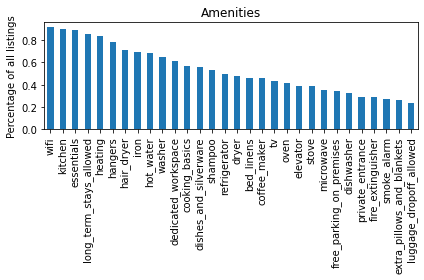

In [22]:
ax = (amenities.sum()/amenities.shape[0]).sort_values( ascending=False ).head(30).plot.bar()
ax.set_ylabel( "Percentage of all listings" );
ax.set_title( "Amenities" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "amenities" )

How many columns in amenities have only one single entry?

In [23]:
sparse_columns = amenities.loc[:,amenities.sum()==1].columns
print( sparse_columns )

Index(['gaggenau_oven', 'paid_parking_garage_on_premises_–_20_spaces',
       '55"_hdtv_with_apple_tv,_chromecast,_netflix,_standard_cable',
       'private_outdoor_heated_rooftop_pool', 'fast_wifi_–_248_mbps',
       'gaggenau_electric_stove', '55"_hdtv_with_netflix,_apple_tv',
       'dedicated_workspace:_desk,_table,_office_chair,_and_monitor',
       'nivea__body_soap', 'aqua_di_parma_conditioner',
       ...
       'four_micro-onde_combiné_grill_marque_weber_oven', 'no_body_soap',
       'no_shampoo', 'yes_oven', 'yes_refrigerator',
       'hdtv_with_chromecast,_netflix,_standard_cable',
       'pain_de_savon_bio__body_soap',
       'divers_(nuxe,_le_petit_marseillais,_well...)_body_soap',
       'divers_(nuxe,_le_petit_marseillais,_well...)_shampoo',
       'divers_(nuxe,_le_petit_marseillais,_well...)_conditioner'],
      dtype='object', length=613)


There are 521 columns with only one entry. They cary valuable information. The description shows that they are quite specific in their formulation and could possibly be summarized in one of the more popular categories.

In order to get some more structure into amenities we make some data cleaning. Build a category dict by hand.

In [24]:
categories = {
    "stove" : re.compile( "stove|^(?!.*provenant).*oven" ),
    "refrigerator" : re.compile( "refrigerator|freezer" ),
    "wifi" : re.compile( "wifi" ),
    "sound_system" : re.compile( "^(?!.*tv).*sound_system" ),
    "air_conditioning" : re.compile( "air_conditioning" ),
    "patio_or_balcony" : re.compile( "patio_or_balcony" ),
    "free_parking" : re.compile( "free_.*parking" ),
    "paid_parking" : re.compile( "paid_.*parking" ),
    "soap" : re.compile( "soap|shampoo|conditioner|shower_gel" ),
    "clothing_storage" : re.compile( "clothing_storage" ),
    "hair_dryer" : re.compile( "hair_dryer" ),
    "dryer" : re.compile( "^(?!hair_dryer).*dryer" ),
    "workspace" : re.compile( "workspace" ),
    "children’s_books_and_toys" : re.compile( "children’s_books_and_toys" ),
    "hot_tub" : re.compile( "hot_tub|rooftop_pool" ),
    "coffee_maker" : re.compile( "coffee_maker|nespresso_machine" ),
    "smoke_alarm" : re.compile( "smoke_alarm|carbon_monoxide_alarm" ),
    "tv" : re.compile( "^tv.*|.*tv$" ),
    "washer" : re.compile( "^(?!dish_washer).*washer" ),
    "dish_washer" : re.compile( "dish_washer" )
}

Add the top runners to the categories. Top runners are those columns with more than a given threshold portion not null:

In [25]:
def add_top_runner_to_categories( df, category, threshold ) :
    """
        add top runner categories from df to categories
        
        Parameter:
        df(DataFrame) : input dataframe
        category(dict) : dict with column names as keys and re's as values
        threshold(float) : only consider columns with >= threshold not null values
        
        Output:
        dict : new category dict
    """
    new_categories = categories.copy()
    for col in tqdm( amenities.columns ) :
        if ( amenities[col].sum()/amenities.shape[0] >= threshold ) :
            # make sure col is not yet matched by an already existing re
            double = False
            for excol, match in new_categories.items():
                if ( match.search(col) ) :
                    double = True
                    break
            if ( not double ) :
                new_categories[col] = re.compile( col )
    
    return new_categories

We concentrate on those with at least 5 percent not null entries:

In [26]:
new_categories = add_top_runner_to_categories( amenities, categories, 0.05 )

100%|██████████| 1046/1046 [00:00<00:00, 2669.38it/s]


In [27]:
def collapse_columns( df, categories ) :
    """
        Reduce the number of columns by their name. 
        Combines the values over collapsed columns into new columns by logical or operator.
        Raises a ValueError in case of overlapping categories.
        Drops empty columns
        
        Parameter:
        df(DataFrame): input data with a numeric dtype
        categories(dict): a dict containing new column names as keys and re's to match on old column names.
        
        Returns:
        DataFrame: resulting df with a reduced number of columns 
        dict: a dictionary with a mapping fomr old column names to new column names
    
    """
    old_to_new = dict()
    df_new = df.copy()
    df_new.drop( df_new.columns, axis=1, inplace=True )
    
    for cat, match in tqdm(categories.items()) :
        
        df_new[cat] = 0
        
        for col in df.columns :
            
            if ( df[col].isnull().all() ) :
                old_to_new[col] = None
            elif ( match.search( col ) ) :
                df_new[cat] |= df[col]
                if col in old_to_new.keys() :
                    raise ValueError( "%s allready matched to %s" % (col, old_to_new[col]) )
                old_to_new[col] = cat
    
    for col in df_new.columns :
        if ( (df_new[col]==0).all() ) :
            df_new.drop( [col], axis=1, inplace=True )
    
    
    return df_new, old_to_new

In [28]:
new_amenities, old_to_new = collapse_columns( amenities, new_categories )
print( "new_amenities contains now %s categories" % new_amenities.shape[1] )

100%|██████████| 62/62 [00:17<00:00,  3.50it/s]

new_amenities contains now 61 categories


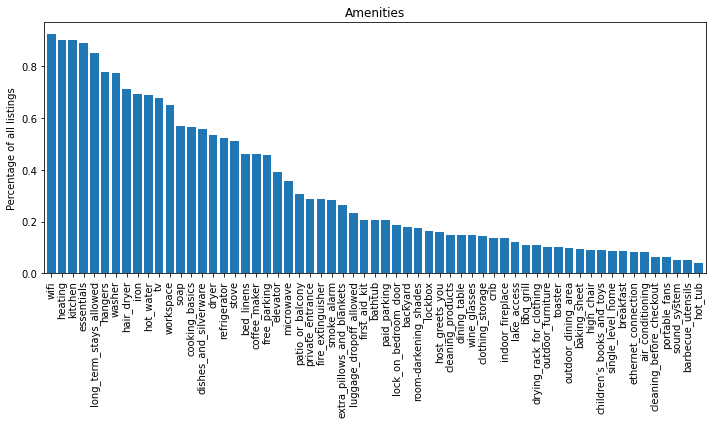

In [29]:
ax = (new_amenities.sum()/new_amenities.shape[0]).sort_values( ascending=False ).plot.bar( width=0.8, figsize=(10, 6) )
ax.set_ylabel( "Percentage of all listings" );
ax.set_title( "Amenities" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "amenities" )

What are the top-10 amenities with their percentage?

In [30]:
(new_amenities.sum()/new_amenities.shape[0]).sort_values( ascending=False ).head(10)

wifi                       0.923477
heating                    0.902092
kitchen                    0.900012
essentials                 0.890764
long_term_stays_allowed    0.851578
hangers                    0.778292
washer                     0.772859
hair_dryer                 0.711594
iron                       0.693215
hot_water                  0.687782
dtype: float64

### What are the prices?

The price column seems to be a text column with a leading $ character:

In [31]:
listings.price.describe()

count        8651
unique        561
top       $100.00
freq          299
Name: price, dtype: object

In [32]:
listings.price.head(5)

0    $100.00
1    $195.00
2    $200.00
3     $60.00
4    $200.00
Name: price, dtype: object

Do we have a price for every listing?

In [33]:
listings.price.notnull().sum() == listings.shape[0]

True

Generate a new column containing the price as a float:

In [34]:
listings["dollar_price"] = listings.price.str.replace( "[$,]", "" ).astype(float)

<ipython-input-34-b6f6a35f612e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  listings["dollar_price"] = listings.price.str.replace( "[$,]", "" ).astype(float)


Get an understanding of the prices:

In [35]:
listings.dollar_price.describe()

count    8651.000000
mean      153.930181
std       288.274586
min         0.000000
25%        70.000000
50%       100.000000
75%       155.000000
max      9840.000000
Name: dollar_price, dtype: float64

Interestingly, there are 0$ items:

In [36]:
(listings.dollar_price == 0).sum()

2

In [37]:
listings[listings.dollar_price==0.]

,id,scrape_id,last_scraped,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,dollar_price
1375,46326518,20211228000812,2021-12-28,citizenM Zurich,NaN,NaN,374971781,CitizenM,2020-11-09,"Zürich, Zurich, Switzerland",...,4.56,NaN,f,1,0,0,0,1.45,zurich,0.0
1617,46327775,20211226165745,2021-12-26,citizenM Geneva,NaN,NaN,374979867,CitizenM,2020-11-09,"Geneva, Geneva, Switzerland",...,4.57,NaN,f,1,0,0,0,2.74,geneva,0.0


It can be assumed, that this is not a valid listing. Meanwhile, the given url to the listing shows a non-zero price tag. Therefore we inject a mean-value as price for the further analysis:

In [38]:
listings['dollar_price'].replace( 0.0, listings.dollar_price.mean(), inplace=True)

How are the prices distributed in the market?

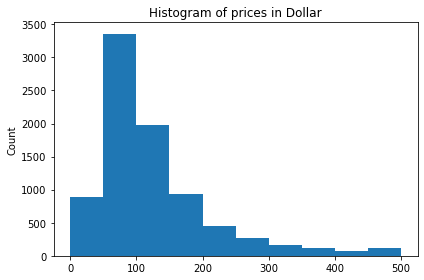

In [39]:
ax = listings.dollar_price.plot.hist(range=(0.0, 500.), title = "Histogram of prices in Dollar" )
ax.set_ylabel( "Count" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "prices" )

## Question 2: What do the reviews tell us?

Reviews have grown since the beginning of the date-Series:

In [40]:
reviews.date = pd.to_datetime( reviews.date )

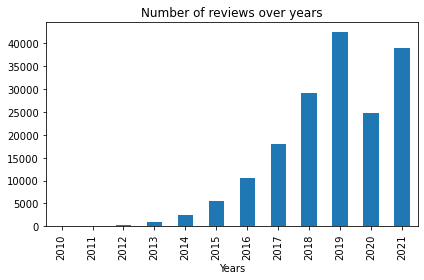

In [41]:
yearly_reviews = reviews.id.groupby(reviews["date"].dt.year).count()
ax = yearly_reviews.plot(kind="bar", title="Number of reviews over years" )
ax.set_xlabel( "Years" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "reviews_over_year" )

The highest number of reviews is in 2019. 2020 shows a massive reduction of reviews going down to the level of 2018. This might be an effect of COVID19-regulations.

Compute growth rates:

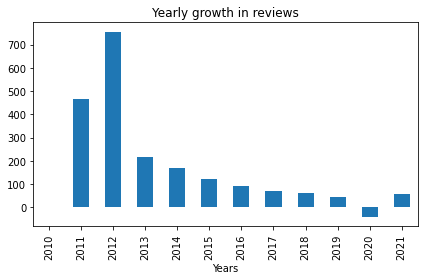

In [42]:
reviews_growth = yearly_reviews.rename("yearly_reviews").to_frame()
reviews_growth["change"] = reviews_growth.pct_change()*100.
ax = reviews_growth["change"].plot(kind="bar", title="Yearly growth in reviews" )
ax.set_xlabel( "Years" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "change_rates" )

Mean growth rates since 2010:

In [43]:
reviews_growth.mean()

yearly_reviews    14430.166667
change              183.186539
dtype: float64

#### Do we have seasonal effects?

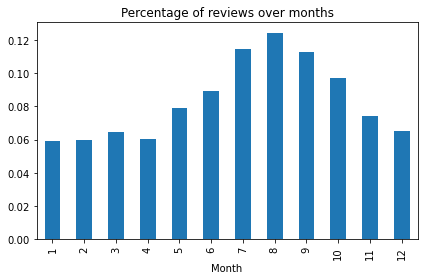

In [44]:
ax = (reviews.id.groupby(reviews["date"].dt.month).count()/reviews.shape[0]).plot(kind="bar", title="Percentage of reviews over months" )
ax.set_xlabel( "Month" );
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "seasons" ) 

There are more reviews during summer and late summer in Switzerland than during winter or spring season.

The latest date in terms of the dataset is given by the scrape-date in listings:

In [45]:
listings.last_scraped = pd.to_datetime( listings.last_scraped )
now_date = listings.last_scraped.max()
now_date

Timestamp('2021-12-28 00:00:00')

Get all reviews within the last 365 days from now_date:

In [46]:
start_date = pd.DateOffset(days=-365)+pd.Timestamp( now_date )
reviews_365 = reviews[reviews.date >= start_date]

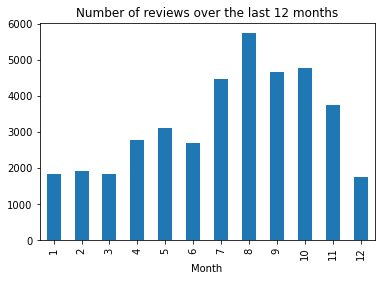

In [47]:
ax = reviews_365.id.groupby(reviews_365["date"].dt.month).count().plot(kind="bar", title="Number of reviews over the last 12 months");
ax.set_xlabel( "Month" );

Obviously we have a higher number of reviews in the second semester of 2021 than in the first. This might be due to COVID19-regulations reducing the number of bookings in the early months of the year. The 2021 distribution looks quite different to the one over all years above.

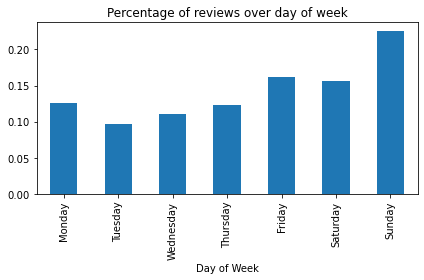

In [48]:
ax = (reviews.id.groupby(reviews["date"].dt.dayofweek).count()/reviews.shape[0]).plot(kind="bar", title="Percentage of reviews over day of week" )
ax.set_xlabel( "Day of Week" );
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "day_of_week" )

When looking at the day of week of the review, we see more than twenty percent on Sundays and only ten percent on Tuesdays.

How many reviewers do we have? Show the top ten reviewers with their number of reviews:

In [49]:
top_reviewers = reviews.reviewer_id.groupby( reviews.reviewer_id ).count().sort_values( ascending=False )
top_reviewers.head(10)

reviewer_id
26960561     55
6767178      37
368668312    36
15660298     31
23279882     30
89170814     29
86275054     27
125644493    26
5290071      25
382285618    24
Name: reviewer_id, dtype: int64

There are indications, that reviewers with multiple reviews, review the same listing more than once. Here are the reviews of the top candidate in the above list. Quentin has written 31 reviews for one listing within three years:

In [50]:
influencer = reviews[reviews.reviewer_id==top_reviewers.index[0]]
influencer = influencer.drop( ["id", "city"], axis=1 )
dp_report.add_table( influencer, "influencer" )
influencer

,listing_id,date,reviewer_id,reviewer_name,comments
10022,6266377,2015-10-10,26960561,Quentin,J'ai été très bien accueilli par Frédérique.\r...
64970,41746054,2020-05-08,26960561,Quentin,"L'appartement de Mandira est très bien placé, ..."
64971,41746054,2020-05-29,26960561,Quentin,Toujours parfait ! Merci à Mandira pour son ho...
64975,41746054,2020-06-26,26960561,Quentin,"Toujours très bien accueilli chez Mandira, je ..."
64981,41746054,2020-07-10,26960561,Quentin,J'ai encore une fois passé un très bon séjour ...
64985,41746054,2020-07-31,26960561,Quentin,"Excellent séjour, je recommande !"
64988,41746054,2020-08-14,26960561,Quentin,"Super séjour chez Mandira, je recommande !"
64991,41746054,2020-08-28,26960561,Quentin,"Excellent séjour, je recommande !"
64993,41746054,2020-09-04,26960561,Quentin,"Mandira est très sympathique et accueillante, ..."
64997,41746054,2020-09-11,26960561,Quentin,"Très bon séjour, je recommande !"


In [51]:
reviews.iloc[np.where( reviews.reviewer_id==top_reviewers.index[0] )].listing_id.value_counts()

41746054    54
6266377      1
Name: listing_id, dtype: int64

In [52]:
multiple_reviews = reviews.groupby( ["reviewer_id"] ).listing_id.value_counts().sort_values( ascending=False )
multiple_reviews.rename( "multiple_reviews_count", inplace=True )
multiple_reviews = multiple_reviews.reset_index()
multiple_reviews

,reviewer_id,listing_id,multiple_reviews_count
0,26960561,41746054,54
1,15660298,3073966,31
2,86275054,12531745,24
3,101206495,898829,19
4,6767178,19820423,19
...,...,...,...
168392,36432009,3096833,1
168393,36432401,29838232,1
168394,36432654,4887567,1
168395,36433903,4797373,1


In [53]:
reviewer_name = reviews.groupby( ["reviewer_id"] ).reviewer_name.first()

In [54]:
review_count = pd.merge( multiple_reviews, reviewer_name.to_frame(), on="reviewer_id" ).sort_values( "multiple_reviews_count", ascending=False )
review_count

,reviewer_id,listing_id,multiple_reviews_count,reviewer_name
0,26960561,41746054,54,Quentin
2,15660298,3073966,31,Felix
3,86275054,12531745,24,Stephan
5,101206495,898829,19,Ali
6,6767178,19820423,19,Joelle
...,...,...,...,...
58368,388511163,47438688,1,Alexandre
58369,388516223,47310245,1,Olivier
58370,388563899,42537709,1,Arnaud
58371,388523618,38408552,1,Barbara


In [55]:
review_subset = review_count[review_count.multiple_reviews_count>=10]
num_reviews = review_subset.multiple_reviews_count.sum()
num_reviewers = len(review_subset.reviewer_id.unique())
num_listings = len(review_subset.listing_id.unique())
print( "%s reviews have been written by %s reviewers about %s listings." % (num_reviews, num_reviewers, num_listings))

326 reviews have been written by 19 reviewers about 20 listings.


In [56]:
most_active_reviewers = review_subset[["reviewer_name", "multiple_reviews_count", "listing_id"]]
dp_report.add_table( most_active_reviewers, "most_active_reviewers")

## Question 3: How can you optimize your revenue as a host?
### Estimate the number of Bookings and Revenue

In the following we estimate the number of bookings, the duration of bookings and the earnings based on the "San Francisco Model" discussed [here](http://insideairbnb.com/about.html).

We assume, that 50 percent of guests write a review. Hence, we can double the number of reviews to estimate a total count of bookings for every listing. We do this for a future 12 month range based on the last 12 months:

In [57]:
listings["number_of_bookings_12m"] = listings.number_of_reviews_ltm * 2

Check if there are listings without estimated number of booked nights:

In [58]:
listings["number_of_bookings_12m"].isnull().any()

False

We assume an average length of stay of 3 nights per booking in general. If there is a minimum length of stay given by the host, we adjust the values to this minimum length. 

In [59]:
listings["average_length_of_stay"] = 3
listings["average_length_of_stay"].clip( lower=listings["minimum_nights_avg_ntm"], inplace=True )

The 12-month occupancy is estimated from the number of bookings and the average length. The total occupancy is capped to 70% according to the model given in the above link.

In [60]:
listings["estimated_occupied_nights"] = listings["number_of_bookings_12m"]*listings["average_length_of_stay"]
listings["estimated_occupied_nights"].clip( upper=0.7*365, inplace=True )

The estimated revenue is the product of estimated nights and price:

In [61]:
listings["estimated_revenue"] = listings["estimated_occupied_nights"].astype(float).multiply( listings["dollar_price"] )

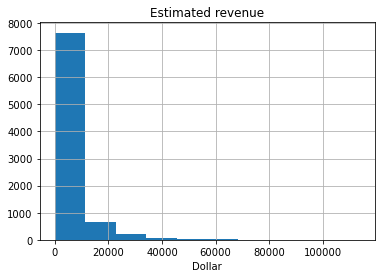

In [62]:
ax = listings["estimated_revenue"].hist()
ax.set_xlabel( "Dollar" )
ax.set_title( "Estimated revenue" );

Most revenues are in the range 0 to 10000 Dollars per year. But there are some top earners as well.
What are the top 10 earning hosts and their estimated revenue?

In [63]:
top_earners = listings[["host_id", "estimated_revenue"]].groupby(listings["host_id"]).sum().sort_values( by="estimated_revenue", ascending=False ).head(10)
dp_report.add_table( top_earners, "top_earners" )
top_earners

,host_id,estimated_revenue
host_id,,
12886487,1172670317,1101069.6
3528377,374007962,922229.0
475053,8550954,516103.5
23561865,871789005,480331.5
16703823,1236082902,436938.0
8382530,276623490,415387.2
179365953,1793659530,335604.3
13570663,502114531,319135.9
134680524,2289568908,293340.0


### Build a model to predict revenue

Select numeric columns as input for the model.

In [64]:
num_vars = listings.select_dtypes( include=np.number )
num_vars.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,dollar_price,number_of_bookings_12m,average_length_of_stay,estimated_occupied_nights,estimated_revenue
count,8.651000e+03,8.651000e+03,8.651000e+03,8502.000000,8502.000000,8651.000000,8651.000000,8651.000000,0.0,7631.000000,...,8651.000000,8651.000000,8651.000000,8651.000000,6682.000000,8651.000000,8651.000000,8651.000000,8651.000000,8651.000000
mean,3.175336e+07,2.021121e+13,1.141312e+08,17.315455,17.315455,46.607688,6.974121,3.104612,NaN,1.530337,...,11.790660,10.846954,0.879783,0.013293,0.869328,153.965768,9.232459,9.146480,32.230910,4155.716233
std,1.595765e+07,1.142476e+07,1.238848e+08,84.566232,84.566232,0.428827,0.870274,1.992481,NaN,0.967813,...,28.725828,28.714854,1.958971,0.154871,1.200746,288.265081,19.227363,77.998839,55.757352,8752.676375
min,7.381000e+03,2.021120e+13,2.667000e+03,0.000000,0.000000,46.142170,5.994620,0.000000,NaN,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.010000,9.000000,0.000000,3.000000,0.000000,0.000000
25%,1.831148e+07,2.021120e+13,1.670382e+07,1.000000,1.000000,46.275255,6.197030,2.000000,NaN,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.150000,70.000000,0.000000,3.000000,0.000000,0.000000
50%,3.448940e+07,2.021120e+13,5.911288e+07,1.000000,1.000000,46.498610,6.646570,2.000000,NaN,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.440000,100.000000,2.000000,3.000000,6.000000,390.000000
75%,4.586619e+07,2.021123e+13,1.759829e+08,4.000000,4.000000,46.654709,7.085600,4.000000,NaN,2.000000,...,5.000000,2.000000,1.000000,0.000000,1.050000,155.000000,10.000000,5.000000,40.000000,4528.000000
max,5.401237e+07,2.021123e+13,4.367388e+08,3552.000000,3552.000000,47.431290,8.604800,16.000000,NaN,18.000000,...,149.000000,149.000000,18.000000,3.000000,15.140000,9840.000000,344.000000,6666.000000,255.500000,113616.000000


Drop bathrooms, calendar, and license, since they are empty.

In [65]:
print( num_vars.bathrooms.isna().all() )
print( num_vars.license.isna().all() )
print( num_vars.calendar_updated.isna().all() )
num_vars = num_vars.drop( ["bathrooms", "license", "calendar_updated"], axis=1 )

True
True
True


Drop IDs, since they can not explain the data.

In [66]:
num_vars = num_vars.drop( ["id","scrape_id", "host_id" ], axis=1 )

Drop longitude and latitude, we use the rating of the location instead.

In [67]:
num_vars = num_vars.drop( ["longitude", "latitude"], axis=1 )

Remove the temporary variables we introduced above.

In [68]:
num_vars = num_vars.drop( ["number_of_bookings_12m", "average_length_of_stay", "estimated_occupied_nights"], axis=1 )

Remove the calculated variables introduced by airbnbinside.

In [69]:
num_vars = num_vars.drop( [c for c in filter( lambda s : s.startswith( "calculated_" ), num_vars.columns.to_list() ) ], axis=1 )
num_vars = num_vars.drop( ["minimum_minimum_nights", 
                           "maximum_minimum_nights", 
                           "minimum_maximum_nights", 
                           "maximum_maximum_nights",
                           "minimum_nights_avg_ntm",
                           "maximum_nights_avg_ntm"], 
                         axis=1 )

Add the amenities from question 1 as well:

In [70]:
num_vars = pd.concat( [num_vars, new_amenities.astype("uint8")], axis=1 )

Add categorical columns from listings:

In [71]:
cat_columns = ["property_type", "room_type", "has_availability", "instant_bookable"]

In [72]:
def create_dummy_df(df, cat_cols, dummy_na):
    """
    Parameters:
    df(DataFrame): pandas dataframe with categorical variables you want to dummy
    cat_cols(List): list of strings that are associated with names of the categorical columns
    dummy_na(bool): Bool holding whether you want to dummy NA vals of categorical columns or not
    
    Returns:
    df(DataFrame): a new dataframe that has the following characteristics:
            1. contains no collumns not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    """
    res = df[cat_cols]
    for col in cat_cols :
        try:
            res = pd.concat([res.drop(col, axis=1), pd.get_dummies(res[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue

    return res

In [73]:
cat_vars = create_dummy_df( listings, cat_columns, False )

Put numerical and categorical together:

In [74]:
all_vars = pd.concat( [num_vars, cat_vars], axis=1 )

Fill NaN values for the columns. First have a look at the portion of NaNs:

In [75]:
(all_vars.isna().sum()/all_vars.shape[0]).sort_values( ascending=False ).head(20)

review_scores_accuracy                               0.240203
review_scores_value                                  0.240203
review_scores_location                               0.240203
review_scores_communication                          0.240203
review_scores_checkin                                0.240203
review_scores_cleanliness                            0.240203
review_scores_rating                                 0.227604
reviews_per_month                                    0.227604
bedrooms                                             0.117905
beds                                                 0.037915
host_listings_count                                  0.017223
host_total_listings_count                            0.017223
property_type_Private room in bed and breakfast      0.000000
property_type_Private room in chalet                 0.000000
property_type_Entire vacation home                   0.000000
property_type_Entire villa                           0.000000
property

* Drop the rows, where we have NaN in estimated revenue - it is only 0.02 percent.
* Fill bedrooms and beds with mode, these are discrete in nature.
* Fill the reviews with a mean value. They are missing for 20 percent of the rows.
* Fill minimum_nights_avg_ntm and minimum_nights_avg_mtm with mean value.

In [76]:
all_vars = all_vars.dropna( subset=["estimated_revenue"], axis=0 )
all_vars["beds"] = all_vars.beds.fillna( all_vars.beds.mode() )
all_vars["bedrooms"] = all_vars.bedrooms.fillna( all_vars.bedrooms.mode() )
fill_mean = lambda col : col.fillna( col.mean() )
all_vars = all_vars.apply( fill_mean, axis=0 )

#### Fit a model on all variables

In [77]:
class LRResult( object ) :
    """ 
        a class to transport results from a linear regression
    """
    
    def __init__( self, 
                 X,
                 y,
                 X_train = None, 
                 X_test = None, 
                 y_train = None, 
                 y_test = None, 
                 lm_model = None, 
                 r2_scores_test = None,
                 r2_scores_train = None,
                 test_size = 0.3,
                 random_state = 42 ) :
        """
            X: X-Matrix
            y: response
            X_train: training set of X
            X_test: test set of X
            y_train: test set of y
            y_test: test set of y
            lm_model: the linear model
            r2_scores_test: r2 scores on the test data
            r2_scores_train: r2 scores on the training data
            test_size(float) : between 0 and 1, default 0.3, determines the portion of data used as test data
            random_state(int) : default 42, initialize the random-number generator to select train and test data
        """
        self.X = X
        self.y = y
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.lm_model = lm_model
        self.r2_scores_test = r2_scores_test
        self.r2_scores_train = r2_scores_train
        self.test_size = test_size
        self.random_state = random_state
    
    def setup( self ) :
        """ 
            split train and test data
            instanciate lm_model
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split( self.X, 
                                                                                self.y, 
                                                                                test_size = self.test_size, 
                                                                                random_state = self.random_state )
        self.lm_model = LinearRegression( normalize=True )
        
    def fit( self ) :
        """ 
            fit the model and compute r2
        """
        self.lm_model = LinearRegression( normalize=True )
        self.lm_model.fit( self.X_train, self.y_train )
        y_test_preds = self.lm_model.predict( self.X_test )
        y_train_preds = self.lm_model.predict( self.X_train )
        
        self.r2_scores_test = r2_score( self.y_test, y_test_preds )
        self.r2_scores_train = r2_score( self.y_train, y_train_preds )
        
    
    def cutoff( self, num_features ) :
        """
            cutoff the number of features
            
            Parameters:
            num_features(int) : number of non-zero values, drop columns with less than cutoff  non-zero entries
            
            Returns:
            LRResult with a cutoff X-Matrix
        """
        assert(self.X is not None)
        
        # reduce_X = X.iloc[:, np.where((self.X.sum() > num_features) == True)[0]]
        reduce_X = X.iloc[:, np.where((self.X.astype(bool).sum() > num_features) == True)[0]]
        return LRResult( y = self.y, X = reduce_X, test_size = self.test_size, random_state = self.random_state)
    
    def relative_cutoff( self, rel_num_features ) :
        """ 
            similar to cutoff, but with a relative portion of non-zeros
            
            Parameters:
            rel_num_features(float): number of non-zero values, drop columns with less non-zero entries
            
            Returns:
            LRResult with a cutoff X-Matrix
        
        """
        return self.cutoff( num_features = rel_num_features*self.X.shape[0] )
    
    def __repr__( self ) :
        return "LRResult( r-squared score %s @ %s values @ %s features )" % (self.r2_scores_test, self.y_test.shape[0], self.X.shape[1])
    
    def __call__( self, num_features = None, rel_num_features = None ) :
        """
            1. calls cutoff or relative_cutoff if num_features of rel_num_features is given
            2. calls setup
            3. calls fit
            
            Parameters:
            num_features : see cutoff
            rel_num_features : see relative_cutoff
            
            Returns:
            self
        """
        res = self
        assert( None in [num_features, rel_num_features] )
        if (num_features is not None) :
            res = self.cutoff( num_features )
        elif (rel_num_features is not None) :
            res = self.relative_cutoff( rel_num_features )
        res.setup()
        res.fit()
        return res
    
    
    @property
    def coefs( self ) :
        """ 
            Returns: the coeficients of the linear model in a DataFrame
            
        """
        return pd.DataFrame( { "est_int" : self.X_train.columns,
                               "coefs" : self.lm_model.coef_,
                               "abs_coefs" : np.abs( self.lm_model.coef_ ) } )
    
    @property
    def features( self ) :
        return self.X.shape[1]
    
    @property
    def num_values( self ) :
        return self.X.shape[0]

def make_linear_regression( X, y, test_size=0.3, random_state=42 ) :
    """
        Fit a linear regression model with X-Matrix X and response y
        
        Parameters:
        X(DataFrame) : X-Matrix
        y(DataFrame): y, response variable
        test_size(float) : between 0 and 1, default 0.3, determines the portion of data used as test data
        random_state(int) : default 42, initialize the random-number generator to select train and test data
        
        Returns:
        LRResult
    
    """
    res = LRResult( X=X, y=y, test_size=test_size, random_state=random_state )
    return res()

The use of all features gives a very poor fit:

In [78]:
X = all_vars.drop( "estimated_revenue", axis=1 )
y = all_vars["estimated_revenue"]

make_linear_regression( X, y )

LRResult( r-squared score -1.8968276631951338e+23 @ 2596 values @ 155 features )

#### Find the best fitting model for a range of cutoffs

In [79]:
cutoffs = trange( 3, 800, 5 )
lr = LRResult( X, y )
fits = list( map( lr, cutoffs ) )

100%|██████████| 160/160 [00:03<00:00, 41.67it/s]


In [80]:
fit_df = pd.DataFrame()
fit_df["cutoffs"] = cutoffs
fit_df["r2_scores_test"] = [ f.r2_scores_test for f in fits ]
fit_df["r2_scores_train"] = [ f.r2_scores_train for f in fits ]
fit_df["features"] = [ f.features for f in fits ]
fit_df.describe()

,cutoffs,r2_scores_test,r2_scores_train,features
count,160.000000,160.000000,160.000000,160.000000
mean,400.500000,0.437101,0.529888,90.106250
std,231.660671,0.001446,0.003120,7.963436
min,3.000000,0.428070,0.525257,78.000000
25%,201.750000,0.436568,0.527274,84.000000
50%,400.500000,0.437066,0.529469,89.000000
75%,599.250000,0.438343,0.532013,94.000000
max,798.000000,0.438657,0.547477,133.000000


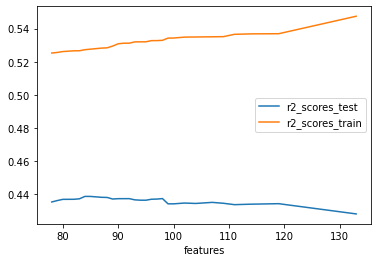

In [81]:
ax = fit_df.plot( x="features", y=["r2_scores_test", "r2_scores_train"] )

The above figure illustrates the number of features in the model on the x-axis and the r2-score for train and test data on the y-axis.

Already at the lowest number of features there is a gap between train and test r2-scores. The linear regression model does not explain all responses.

With an increasing number of features in the model the fit on the train data becomes slightly better. But already from slightly more than 80 features upwards we see a decrease in the r2-score of the prediction on the test data set. This is in contrast to the train data, were including more features increases the r2-score. Such an effect is called overfitting.

In the following we select the model with the best r2-score:

In [82]:
fits.sort( key = lambda f : f.r2_scores_test, reverse=True )

In [83]:
best = fits[0]
best

LRResult( r-squared score 0.43865693045070775 @ 2596 values @ 84 features )

### Which features have most impact on the revenue

In [84]:
impact = best.coefs.sort_values( ["abs_coefs"], ascending=False )
dp_report.add_table( impact, "impact" )
impact.head(20)

,est_int,coefs,abs_coefs
62,lockbox,1311.807656,1311.807656
54,baking_sheet,1239.094191,1239.094191
73,high_chair,1016.303391,1016.303391
78,crib,910.910054,910.910054
72,outdoor_furniture,867.575941,867.575941
35,children’s_books_and_toys,-836.744373,836.744373
26,air_conditioning,818.709794,818.709794
20,review_scores_value,-790.582692,790.582692
13,number_of_reviews_l30d,-770.158673,770.158673
61,cleaning_products,-766.550942,766.550942


Generate a merged DataFrame containing the coefs (scaled to a range 0...1) and the percentage for all amenities:

In [85]:
amenities_percentage = (new_amenities.sum()/new_amenities.shape[0]).rename("precentage_of_listings").to_frame()
impact_and_percentage = pd.merge( impact, amenities_percentage, left_on="est_int", right_index=True ).set_index("est_int").drop(["coefs"],axis=1)
impact_and_percentage.abs_coefs /= impact_and_percentage.abs_coefs.max()
impact_and_percentage.rename( {"abs_coefs" : "impact_factor", "est_int" : "amenities" }, axis=1,inplace=True )

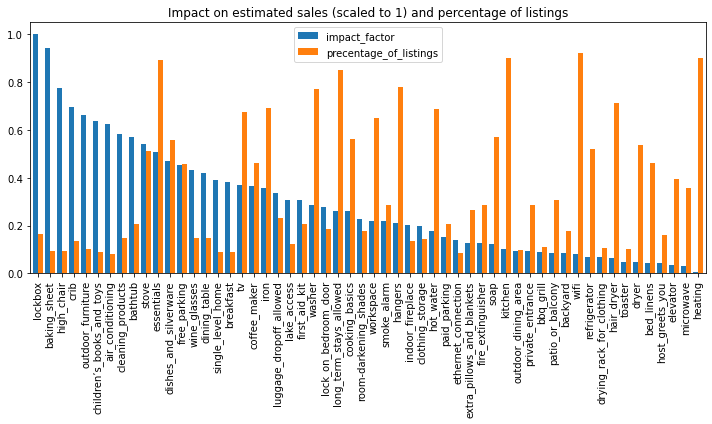

In [86]:
ax = impact_and_percentage.plot.bar( width=0.8, figsize=(10, 6) )
ax.set_title("Impact on estimated sales (scaled to 1) and percentage of listings")
ax.set_xlabel(None);
plt.gcf().set_tight_layout(True)
dp_report.add_plot( ax, "impact_and_percentage" )

#### Upload report to datapane

In [87]:
dp_report.upload( "airbnbcase" )

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/yklvoJ3/airbnbcase-review-score-location/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/M7bKjmk/airbnbcase-room-type/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/M3821Jk/airbnbcase-amenities/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/0kebKOA/airbnbcase-prices/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/n3ZXWMk/airbnbcase-reviews-over-year/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/E7og967/airbnbcase-change-rates/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/v7JR8B7/airbnbcase-seasons/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/VkB9B27/airbnbcase-day-of-week/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/63Ol6R7/airbnbcase-influencer/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/43grG4A/airbnbcase-most-active-reviewers/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/E7ogn67/airbnbcase-top-earners/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/W3QlWaA/airbnbcase-impact/) to view and share your report.

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Report successfully uploaded, click [here](https://datapane.com/u/david17/reports/63OlGR7/airbnbcase-impact-and-percentage/) to view and share your report.